In [1]:
%matplotlib inline

import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

### Data Preprocessing

In [2]:
# filter out non-major albums
major_albums=['1989','Fearless','Lover','Midnights','Red', 'Speak Now', 'Taylor Swift', 'The Tortured Poets Department', 'evermore','folklore','reputation']

songs = (
    pd.read_csv("songs.csv")
    .rename(columns={'Title':'title', 'Album':'album', 'Lyrics':'lyrics'})
    .loc[
        lambda x:x['album'].str.contains("|".join(major_albums))
    ]
    # remove some special versions
    .loc[
        lambda x:x['album']!='The Taylor Swift Holiday Collection - EP'
    ]
    .loc[
        lambda x:x['album']!='1989 (Taylor’s Version) [Deluxe]'
    ]
    .assign(
        album2 = lambda df:df['album'].str.replace("\([^()]*\)","", regex=True).str.replace("The More Fearless  Chapter","Fearless ").str.replace("The More Lover Chapter","Lover").str.replace("evermore ","evermore").str.replace("1989  [Tangerine Edition]","1989", regex=False).str.replace("folklore ", "folklore"),
        # clear the lyric text
        clean_lyrics__ = lambda df:df['lyrics'].str.lower(),
        clean_lyrics_ = lambda df:df['clean_lyrics__'].str.replace('[^\w\s]','', regex=True),
        clean_lyrics = lambda df:df['clean_lyrics_'].str.replace("\n"," ",regex=True),    )
    [['title','clean_lyrics','album2']]
    .rename(columns={
        'album2':'album'
    })
)

In [3]:
songs.head()

,title,clean_lyrics,album
0,22 (Taylor’s Version),it feels like a perfect night to dress up like...,Red
1,All Too Well (10 Minute Version) (Taylor’s Ver...,i walked through the door with you the air was...,Red
2,All Too Well (Taylor’s Version),i walked through the door with you the air was...,Red
3,Babe (Taylor’s Version) [From The Vault],what about your promises promises what about y...,Red
4,Begin Again (Taylor’s Version),took a deep breath in the mirror he didnt like...,Red


In [4]:
def findAlbumYear(row, axis=1):
    if row['album']=='Red ':
        return "2012"
    elif row['album']=='Lover':
        return "2019"
    elif row['album']=='1989':
        return "2014"
    elif row['album']=='Midnights ':
        return "2022"
    elif row['album']=='Taylor Swift ':
        return "2006"
    elif row['album'] =="Speak Now ":
        return "2010"
    elif row['album'] =='Fearless ':
        return "2008"
    elif row['album'] == "reputation":
        return "2017"
    elif row['album'] == "evermore":
        return "2020"
    elif row['album'] == "The Tortured Poets Department":
        return "2024"
    elif row['album'] == 'folklore':
        return "2020"
    
songs['album_year'] = songs.apply(lambda row: findAlbumYear(row), axis=1)

In [5]:
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [6]:
# tokenize the lyrics
songs = (
    songs
    .assign(
        lyrics_tok = lambda df:df.apply(lambda row: nltk.word_tokenize(row['clean_lyrics']), axis=1),
        clean_lyrics2 = lambda df:df['lyrics_tok'].apply(lambda x:' '.join([word for word in x if word not in (stop_words)]))
    )
    [['title','clean_lyrics2','album','album_year']]
    .rename(columns={
        'clean_lyrics2':'clean_lyrics'
    })
)
songs.head()

,title,clean_lyrics,album,album_year
0,22 (Taylor’s Version),feels like perfect night dress like hipsters m...,Red,2012
1,All Too Well (10 Minute Version) (Taylor’s Ver...,walked door air cold somethin bout felt like h...,Red,2012
2,All Too Well (Taylor’s Version),walked door air cold something bout felt like ...,Red,2012
3,Babe (Taylor’s Version) [From The Vault],promises promises promises promises promises v...,Red,2012
4,Begin Again (Taylor’s Version),took deep breath mirror didnt like wore high h...,Red,2012


### Sentiment Analysis

In [7]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Nowucme/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Hey!")
#songs['popularity'] = songs['clean_lyrics']

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [9]:
songs['polarity'] = songs['clean_lyrics'].apply(lambda x:sia.polarity_scores(x))
songs.head(2)

,title,clean_lyrics,album,album_year,polarity
0,22 (Taylor’s Version),feels like perfect night dress like hipsters m...,Red,2012,"{'neg': 0.11, 'neu': 0.547, 'pos': 0.343, 'com..."
1,All Too Well (10 Minute Version) (Taylor’s Ver...,walked door air cold somethin bout felt like h...,Red,2012,"{'neg': 0.082, 'neu': 0.672, 'pos': 0.246, 'co..."


In [10]:
songs[['neg','neu','pos','compound']] = songs['polarity'].apply(pd.Series)
songs.drop('polarity', axis=1)

,title,clean_lyrics,album,album_year,neg,neu,pos,compound
0,22 (Taylor’s Version),feels like perfect night dress like hipsters m...,Red,2012,0.110,0.547,0.343,0.9960
1,All Too Well (10 Minute Version) (Taylor’s Ver...,walked door air cold somethin bout felt like h...,Red,2012,0.082,0.672,0.246,0.9968
2,All Too Well (Taylor’s Version),walked door air cold something bout felt like ...,Red,2012,0.079,0.684,0.237,0.9866
3,Babe (Taylor’s Version) [From The Vault],promises promises promises promises promises v...,Red,2012,0.184,0.635,0.182,-0.3670
4,Begin Again (Taylor’s Version),took deep breath mirror didnt like wore high h...,Red,2012,0.098,0.732,0.170,0.9634
...,...,...,...,...,...,...,...,...
250,I Look in People’s Windows,died tiniest death spied catch breath northbou...,The Tortured Poets Department,2024,0.128,0.742,0.130,-0.2023
251,The Prophecy,hand throttle thought caught lightning bottle ...,The Tortured Poets Department,2024,0.093,0.656,0.251,0.9869
252,Cassandra,new house placing daydreams patching crack alo...,The Tortured Poets Department,2024,0.342,0.615,0.043,-0.9975
253,Peter,forgive peter lost fearless leader closets lik...,The Tortured Poets Department,2024,0.054,0.800,0.146,0.9744


### Compound Sentiment Analysis

In [11]:
#calculate overall sentiment for pos, neg, sentiment
pos = sum(songs['pos'])
neg = sum(songs['neg'])
compound = sum(songs['compound'])

#print the overall sentiments
print("positive: ", pos)
print("negative: ", neg)
print("compound: ", compound)

positive:  49.13199999999997
negative:  33.03899999999999
compound:  90.35880000000006


/var/folders/z_/3m5m7v017337xl97bs9k5sbc0000gn/T/ipykernel_53378/2179479412.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_sentiment = songs.groupby('album_year').sum().reset_index()


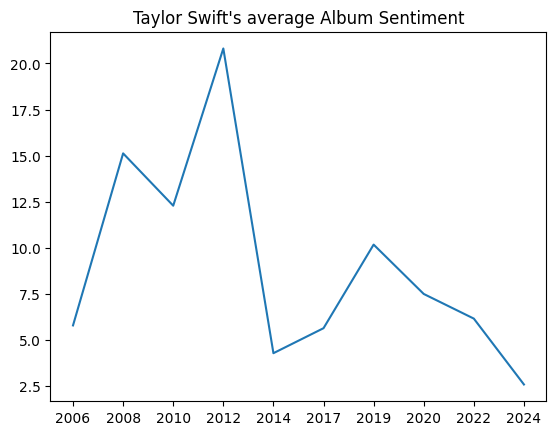

In [12]:
#create a new DataFrame using the groupby method for the album_year
yearly_sentiment = songs.groupby('album_year').sum().reset_index()
#visualize sentiment over time 
plt.plot(yearly_sentiment['album_year'], yearly_sentiment['compound'])
plt.title("Taylor Swift's average Album Sentiment")
plt.show()

In [13]:
yearly_sentiment

,album_year,neg,neu,pos,compound
0,2006,0.800,6.940,2.264,5.7922
1,2008,3.094,17.328,5.579,15.1213
2,2010,2.838,14.827,4.332,12.2842
3,2012,3.481,18.472,7.049,20.8099
4,2014,3.835,13.636,4.527,4.2861
5,2017,2.285,9.631,3.087,5.6416
6,2019,2.696,11.201,5.104,10.1743
7,2020,5.338,21.713,6.949,7.4984
8,2022,3.122,14.188,4.687,6.1615
9,2024,5.550,19.899,5.554,2.5893


### Album Analysis

In [24]:
songs.groupby('album')['compound'].sum()

album
1989                              4.2861
Fearless                         15.1213
Lover                            10.1743
Midnights                         6.1615
Red                              20.8099
Speak Now                        12.2842
Taylor Swift                      5.7922
The Tortured Poets Department     2.5893
evermore                          5.5718
folklore                          1.9266
reputation                        5.6416
Name: compound, dtype: float64

### Song Analysis

In [42]:
songsResult = songs.sort_values(by="compound", ascending=True)[['title','album','album_year','compound']].reset_index(drop=True)
songsResult[:10]

,title,album,album_year,compound
0,Shake It Off (Taylor’s Version),1989,2014,-0.9995
1,This Love (Taylor’s Version),1989,2014,-0.9994
2,I Wish You Would (Taylor’s Version),1989,2014,-0.9993
3,I Knew You Were Trouble (Taylor’s Version),Red,2012,-0.9989
4,Down Bad,The Tortured Poets Department,2024,-0.9985
5,Cassandra,The Tortured Poets Department,2024,-0.9975
6,Bad Blood (Taylor’s Version),1989,2014,-0.9973
7,The Albatross,The Tortured Poets Department,2024,-0.9966
8,Miss Americana & The Heartbreak Prince,Lover,2019,-0.9953
9,I Forgot That You Existed,Lover,2019,-0.9921


In [1]:
#transform data frame to js (for Svelte)
#songsResult.to_json(orient="table", index=None)

"The sentiment is judged by the computer, which might be vastly different from our own judgement."

Data Source:  
https://github.com/shaynak/taylor-swift-lyrics/blob/main/songs.csv  
Reference:  
https://www.youtube.com/watch?v=rcmOa9c874s  
https://medium.com/@felixmutai/tokenization-in-sentiment-analysis-cd386a08fab